In [38]:
#baseline: 90 min in standby mode
#experiment: 15 min interval, video playback of max/medium/min brightness for two rounds

In [39]:
import sys
import logging
from uuid import UUID

import arrow
import emission.core.get_database as edb
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import datetime as pydt
import emission.storage.timeseries.abstract_timeseries as esta
import emission.storage.timeseries.timequery as estt
import public_data


logging.getLogger().setLevel(logging.DEBUG)
logging.debug(sys.path)


android_id = "248d8da2-9288-41b2-a0fe-29c1f2f01932"

In [40]:
# pull data from the server 
server_url = 'https://e-mission.eecs.berkeley.edu'

#overall
start_ts = arrow.get('2016-10-17 14:04:00', 'YYYY-MM-DD HH:mm:ss').timestamp
end_ts = arrow.get('2016-10-17 22:22:00', 'YYYY-MM-DD HH:mm:ss').timestamp

phone_ids = [android_id]

public_data.request_batched_data(server_url, start_ts, end_ts, phone_ids)

Data loaded to local server!


In [41]:
#type: list of emission.storage.timeseries.builtin_timeseries.BuiltinTimeSeries
android_ts = esta.TimeSeries.get_time_series(UUID(android_id))

#time query specification
#overall
start_ts = arrow.get('2016-10-17 14:04:00', 'YYYY-MM-DD HH:mm:ss').timestamp
end_ts = arrow.get('2016-10-17 22:22:00', 'YYYY-MM-DD HH:mm:ss').timestamp

time_range = estt.TimeQuery("metadata.write_ts", start_ts, end_ts)
android_battery_df = android_ts.get_data_df("background/battery", time_range)



# baseline brightness
start_ts0 = arrow.get('2016-10-17 15:44:00', 'YYYY-MM-DD HH:mm:ss').timestamp
end_ts0 = arrow.get('2016-10-17 17:44:00', 'YYYY-MM-DD HH:mm:ss').timestamp

# video playback of various brightness
start_ts1 = arrow.get('2016-10-17 18:55:00', 'YYYY-MM-DD HH:mm:ss').timestamp
end_ts1 = arrow.get('2016-10-17 20:36:00', 'YYYY-MM-DD HH:mm:ss').timestamp


time_list = [(start_ts0, end_ts0), (start_ts1, end_ts1)]
time_range_list = map(lambda t: estt.TimeQuery("metadata.write_ts", t[0], t[1]), time_list)
android_battery_df_list = map(lambda t: android_ts.get_data_df("background/battery", t), time_range_list)

In [42]:
android_battery_df[["fmt_time", "battery_level_pct"]][:2]

,fmt_time,battery_level_pct
0,2016-10-17T15:24:15.947000+00:00,99
1,2016-10-17T15:26:04.213000+00:00,99


In [43]:
import numpy as np

android_xnew = np.arange(start_ts, end_ts, 30) # 30 seconds

android_xnew_list = map(lambda t: np.arange(t[0], t[1], 30), time_list)

In [44]:
import scipy.interpolate as spi
import numpy as np

def get_interpolated(x, y, xnew):
    # fn = spi.interp1d(x=x, y=y, bounds_error=False, fill_value=y.iloc[-1])
    fn = spi.interp1d(x=x, y=y, bounds_error=False)
    #This class returns a function whose call method uses interpolation to find the value of new points.
    return fn(xnew)

In [45]:
def get_interpolated_df(sensor_df, xnew):
    local_dt_new = map(pydt.datetime.fromtimestamp, xnew)
    fmt_time_new = map(lambda dt: dt.isoformat(), local_dt_new)
    #date.isoformat() Return a string representing the date in ISO 8601 format, ‘YYYY-MM-DD’. 
    # -For example, date(2002, 12, 4).isoformat() == '2002-12-04'.
    interpolated_series = get_interpolated(sensor_df.ts, sensor_df.battery_level_pct, xnew)
    # print "interpolated_series = %s" % interpolated_series
    interpolated_df = pd.DataFrame(data={'ts': xnew, 'metadata_write_ts': xnew, 'local_dt': local_dt_new, 'fmt_time': fmt_time_new, 'battery_level_pct': interpolated_series})
    return interpolated_df

In [46]:
android_battery_interp_df = get_interpolated_df(android_battery_df, android_xnew)

android_battery_interp_df_list = map(lambda i: get_interpolated_df(android_battery_df_list[i], android_xnew_list[i]), range(len(android_xnew_list)))


df0
                           fmt_time  battery_level_pct
0  2016-10-17T15:57:57.854000+00:00                 98
1  2016-10-17T16:37:01.889000+00:00                 96
2  2016-10-17T17:08:28.272000+00:00                 95
df1
                           fmt_time  battery_level_pct
0  2016-10-17T18:58:39.308000+00:00                 99
1  2016-10-17T19:52:07.887000+00:00                 73
2  2016-10-17T20:25:30.905000+00:00                 56


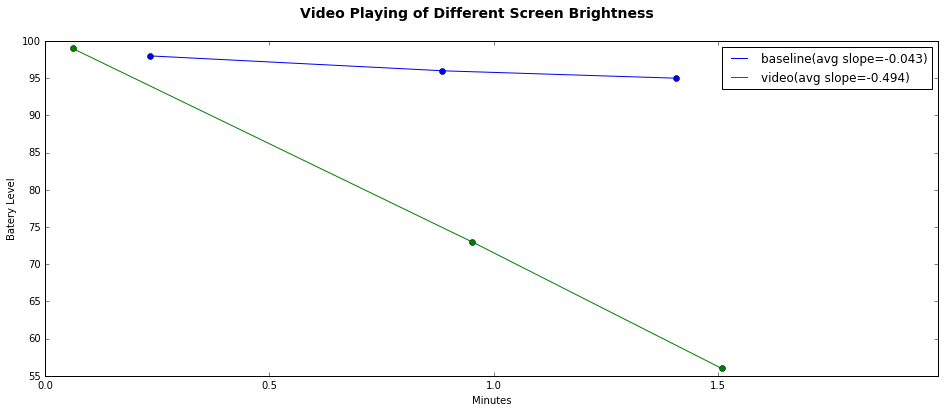

In [47]:
#Android: With interplation on battery data 

(ifig, iaxes2d) = plt.subplots(ncols=1, nrows=1, figsize=(16,6))
iaxes = iaxes2d

ifig.suptitle('Video Playing of Different Screen Brightness', fontsize=14, fontweight='bold')

for i, df in enumerate(android_battery_interp_df_list):
    df['hr'] = (df.ts-time_list[i][0])/3600.0
    df['m'] = df.hr*60.0
    df.plot(x='hr', y='battery_level_pct', style=style_interp[i], label=label[i]+"(avg slope=%s)" % round(slope_list[i], 3), ax=iaxes, legend=True)


for i, df in enumerate(android_battery_df_list):
    print "df" +str(i)
    print df[['fmt_time', 'battery_level_pct']]
    df['hr'] = (df.ts-time_list[i][0])/3600.0
    df['m'] = df.hr*60.0
    df.plot(x='hr', y='battery_level_pct', style=style[i], ax=iaxes, legend=False)
    iaxes.set_xlabel('Minutes')
    iaxes.set_ylabel('Batery Level')
    #plt.xticks(np.arange(min(df.dt), max(df.dt), 1))


In [48]:
from scipy import stats

slope_list=[]
print "From linear model fitting ..." 
for i, df in enumerate(android_battery_interp_df_list):
    df['hr'] = (df.ts-start_ts)/3600.0
    df['m'] = df.hr*60.0
    notnull = df.battery_level_pct.notnull()
    slope, intercept, r_value, p_value, std_err = stats.linregress(df.m[notnull], df.battery_level_pct[notnull])
    print "android %d: " % (i+1)  + "slope="+str(slope) + " %/min  std_err="+str(std_err)
    slope_list.append(slope)

#print "average slope=" + str(sum(slope_list)/len(slope_list)) + " %/min  std dev=" + str(np.std(slope_list))
print "\n avg sw experiment/baseline ratio = " + str(slope_list[1]/slope_list[0])

From linear model fitting ...
android 1: slope=-0.0431561119316 %/min  std_err=0.000403069453928
android 2: slope=-0.493857012758 %/min  std_err=0.000405542140348

 avg sw experiment/baseline ratio = 11.4435010628


In [ ]:
label = ['baseline', 'video']
style = ['ob', 'og', 'or', 'oc']
style_interp = ['b', 'g', 'r', 'c']

ts_to_dt = lambda t: pydt.datetime.fromtimestamp(t)

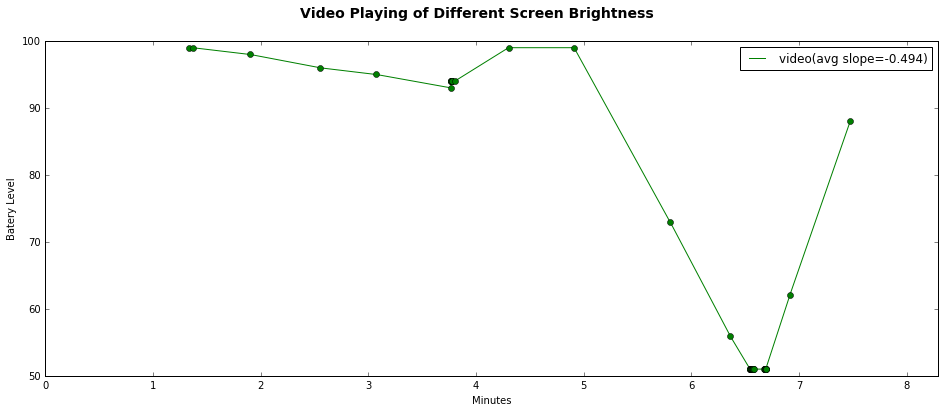

In [25]:
#Android: overall with interplation on battery data 

(ifig, iaxes2d) = plt.subplots(ncols=1, nrows=1, figsize=(16,6))
iaxes = iaxes2d

ifig.suptitle('Video Playing of Different Screen Brightness', fontsize=14, fontweight='bold')

#for i, df in enumerate(android_battery_interp_df_list):
df = android_battery_interp_df
df['hr'] = (df.ts-start_ts)/3600.0
df['m'] = df.hr*60.0
df.plot(x='hr', y='battery_level_pct', style=style_interp[i], label=label[i]+"(avg slope=%s)" % round(slope_list[i], 3), ax=iaxes, legend=True)


#for i, df in enumerate(android_battery_df_list):
df = android_battery_df
df['hr'] = (df.ts-start_ts)/3600.0
df['m'] = df.hr*60.0
df.plot(x='hr', y='battery_level_pct', style=style[i], ax=iaxes, legend=False)
iaxes.set_xlabel('Minutes')
iaxes.set_ylabel('Batery Level')
#plt.xticks(np.arange(min(df.dt), max(df.dt), 1))


(-1, 0.5)

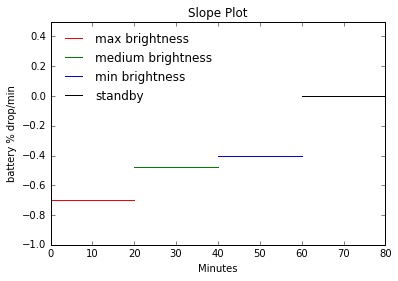

In [175]:
mpl_fig = plt.figure()
ax = mpl_fig.add_subplot(111)


#line, = ax.plot((0, 20), (-0.7, -0.7), 'r-', label='max brightness')

ax.set_title("Slope Plot")
ax.set_xlabel("Minutes")
ax.set_ylabel("battery % drop/min")

plt.plot((0, 20), (-0.7, -0.7), 'r-', label='max brightness')
plt.plot((20, 40), (-0.48, -0.48), 'g-', label='medium brightness')
plt.plot((40, 60), (-0.4, -0.4), 'b-', label='min brightness')
ax = plt.plot((60, 80), (0, 0), 'k-', label='standby')
plt.legend(loc='upper left', frameon=False)
plt.xlim(0,80)
plt.ylim(-1, 0.5)
